In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
import warnings
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Objective

The purpose of this notebook is to experiment with different time series methods to predict the number of rainy days out to a forecast horization of one week (predict the number of rainy day's nextd week based on the past rainy day observations). We'll first look at some baseline models and gradually introduce more complex models.

# Data

In [6]:
weather = pd.read_csv('../data/notebook1_weather_by_day_2019-05-09.csv', parse_dates=['date']).set_index('date')
weather.head()

,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
date,,,,,,,,
2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


Only keep rainy days

In [7]:
rain_days = weather.query('totalPrecipMM >= 0.2')
rain_days.head()

,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
date,,,,,,,,
2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
2010-01-06,0.6,-4.8,-3.0,-3.9,0.0,winter,2010,1


Create a dataset with weekly rainy day counts

In [8]:
targets = rain_days.resample('1W', label='left').size()
targets.tail()

date
2019-04-07    4
2019-04-14    6
2019-04-21    6
2019-04-28    6
2019-05-05    2
Freq: W-SUN, dtype: int64

# Time Series Analysis

## Entire history

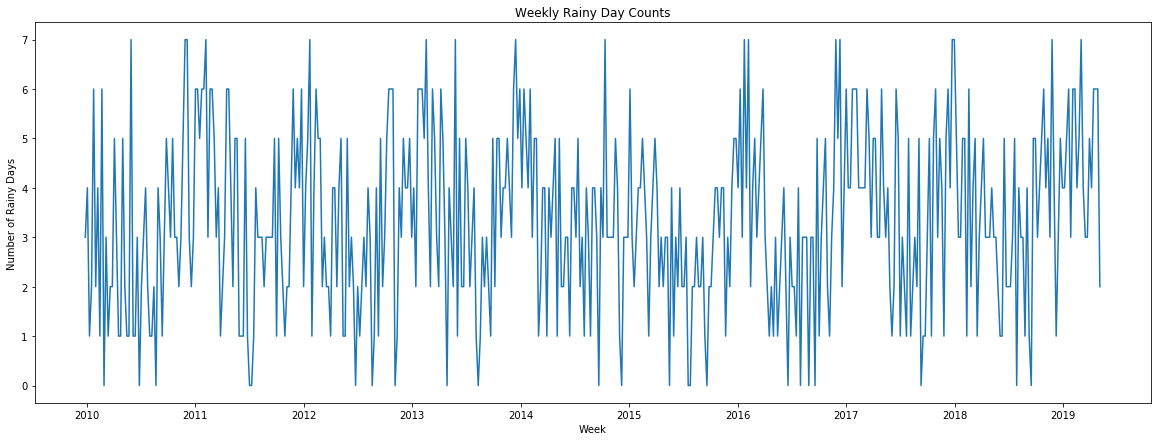

In [9]:
plt.figure(figsize=(20,7))
sns.lineplot(data=targets).set(
  title='Weekly Rainy Day Counts',
  xlabel='Week',
  ylabel='Number of Rainy Days');

Clearly seasonality here - rainy day counts spike at the beginning of the year (here, precipitation is mostly snow) and drop by around June.

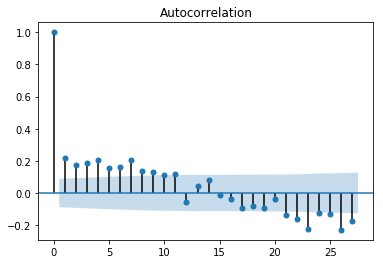

In [10]:
plot_acf(targets);

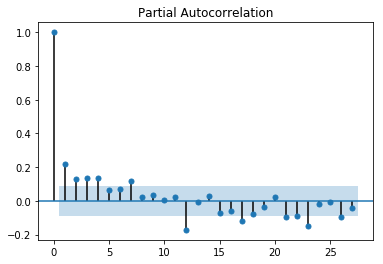

In [11]:
plot_pacf(targets);

Likely many different lags with statistically significant autocorrelations due to the long history of observations (i.e. differently autocorellations at different points in time). Negative correlation is likely explained by the seasonality we see every half year (~26 weeks). What about over the last two years?

## Last two years

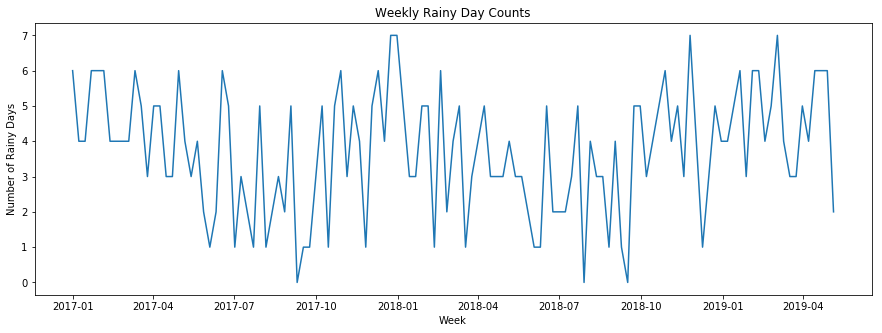

In [17]:
plt.figure(figsize=(15,5))
sns.lineplot(data=targets[targets.index >= '2017-01-01']).set(
  title='Weekly Rainy Day Counts',
  xlabel='Week',
  ylabel='Number of Rainy Days');

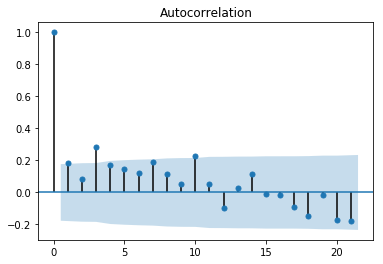

In [18]:
plot_acf(targets[targets.index >= '2017-01-01']);

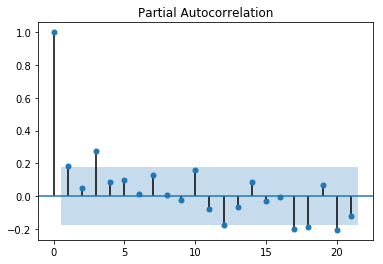

In [19]:
plot_pacf(targets[targets.index >= '2017-01-01']);

Statistically significant autocorrelation at ~4 weeks.

## By year

In [20]:
targets_df = targets.rename('rainy_days').to_frame().assign(
  year=lambda x: x.index.year, 
  month=lambda x: x.index.month, 
  week=lambda x: x.index.week).reset_index()
targets_df.head()

,date,rainy_days,month,week,year
0,2009-12-27,3,12,52,2009
1,2010-01-03,4,1,53,2010
2,2010-01-10,1,1,1,2010
3,2010-01-17,2,1,2,2010
4,2010-01-24,6,1,3,2010


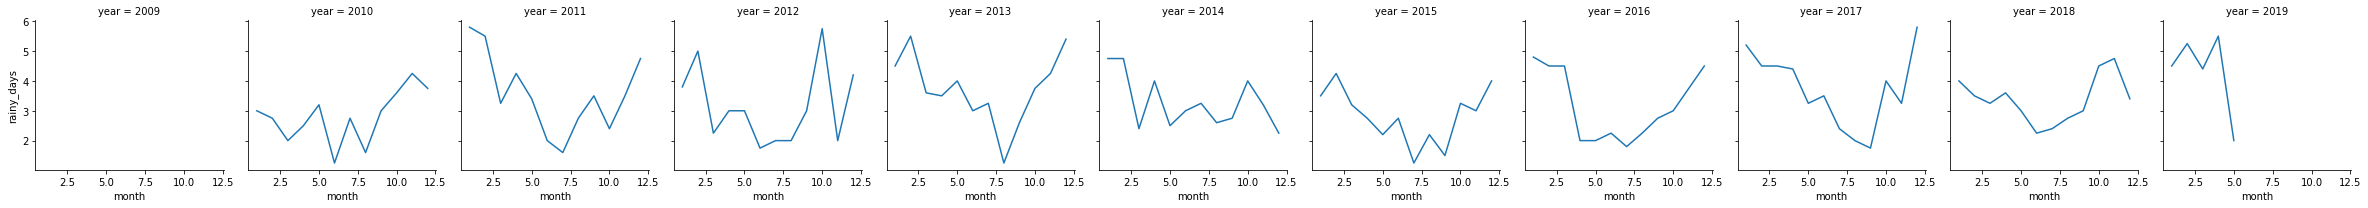

In [21]:
g = sns.FacetGrid(targets_df, col='year')
g.map(sns.lineplot, 'month', 'rainy_days', ci=None);

It looks like if we take the seasonal naive forecasts, we'd have good luck especially over the last three years.

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


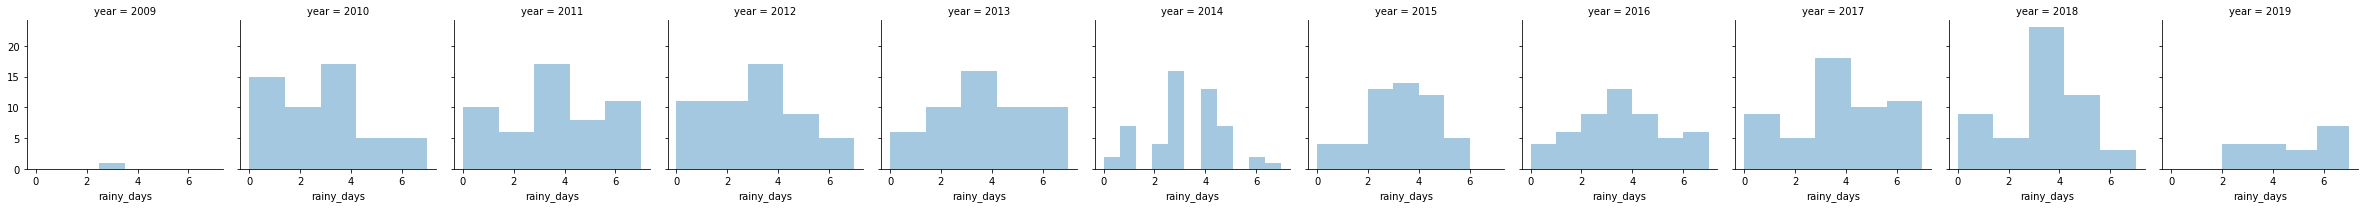

In [22]:
g = sns.FacetGrid(targets_df, col='year')
g.map(sns.distplot, 'rainy_days', kde=False);

## Decomposition

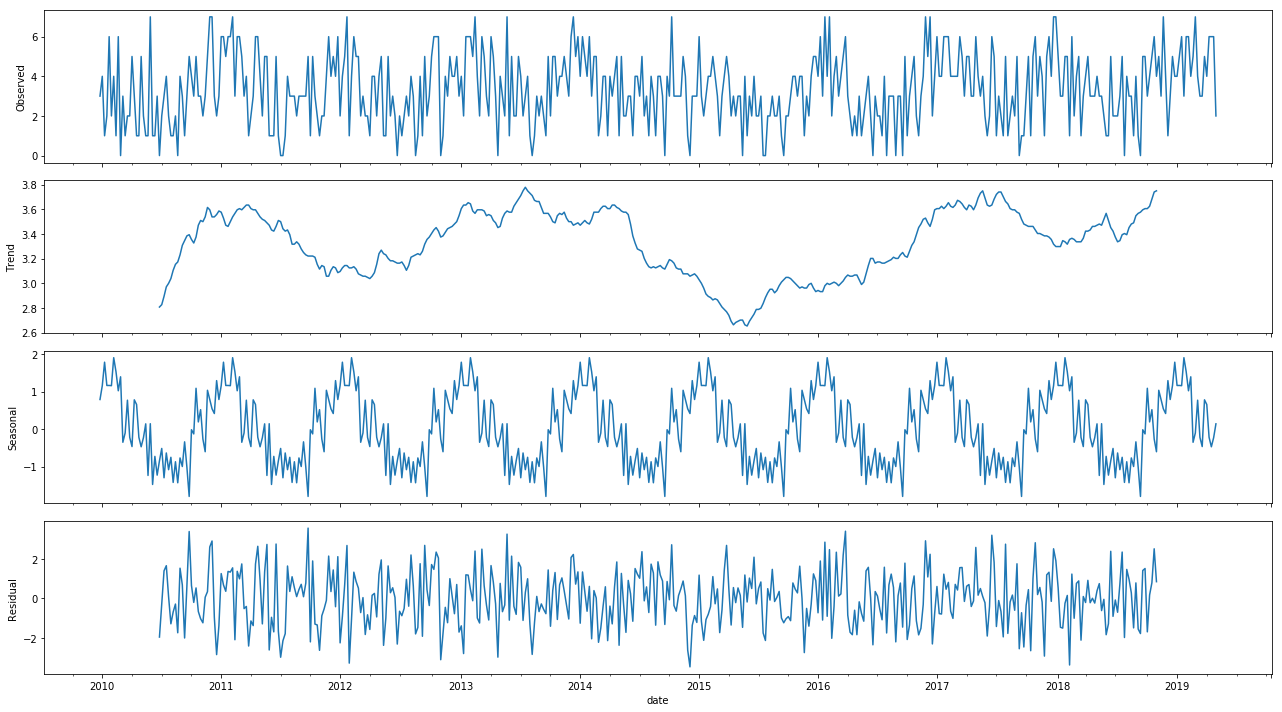

In [33]:
with mpl.rc_context():
  mpl.rc("figure", figsize=(18,10))
  sd = seasonal_decompose(targets, model='additive')
  sd.plot();

There is clear seasonality as we would expect and it looks like there was a regime change following 2015. It looks like there is a cycle that lasts ~4 years during which time the average number of rainy days per week gradually decreases (sharply in the case of 2014). There has been a sharp upturn since the middle of 2018.

# Functions

In [16]:
def results_df(y: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
  """Returns a dataframe with actual, predicted, and error values.
  
  Args:
    actual: Observed values
    predicted: Predicted values

  Returns:
    A dataframe with result values
  """
  df = pd.DataFrame({'actual': y, 'predicted': y_pred}).assign(
    error=lambda x: x['predicted'] - x['actual'])
  return df

In [17]:
def score(results_df: pd.DataFrame) -> float:
  """Returns the score of the results using the `error` column.
  
  Args:
    results_df: A model's results.
    
  Returns:
    The resulting score.
  """
  return np.sqrt((results_df['error']**2).mean())

In [18]:
def display_results(model_name: str, results_df: pd.DataFrame) -> None:
  """Displays the model's score, results over time, and error distribution.
  
  Args:
    results_df: A model's results.
  """
  plt.figure(figsize=(14,5))
  results_df['error'].plot();

  plt.figure(figsize=(14,5))
  results_df['actual'].plot(label='actual');
  results_df['predicted'].plot(label='predicted', style='-');
  plt.legend();
  
  plt.figure()
  results_df['error'].hist();
  
  model_score = score(results_df)
  print('Error:', model_score)
  
  stats = results_df['error'].describe().rename(model_name)
  print('Error stats:')
  print(stats)
  print(confusion_matrix(results_df['actual'], results_df['predicted']))
  return (model_name, model_score, stats, results_df['predicted'])

In [19]:
from typing import Callable

def evalute_model(model_name: str, model: Callable[[pd.Series], pd.Series], y: pd.Series, **args) -> float:
  """Generates predictions using the model and displays the results.
  
  Args:
    model: A model that accepts a series that it uses to make predictions.
    y: The target values.
  """
  y_pred = model(targets, **args)
  results = results_df(y, y_pred).round(0).fillna(0).astype(int)
  return display_results(model_name, results)

# Models

## Naive

Uses the prior week rain day count to predict current week rain day count.

In [48]:
def predict_naive(df):
  return df.shift(1)

Error: 2.234643276509342
Error stats:
count    471.000000
mean       0.004246
std        2.237015
min       -6.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: naive, dtype: float64
[[ 2  5  3  8  1  2  2  0]
 [ 5  9 13 10 12 13  0  3]
 [ 4 11 12 21 10 10  3  2]
 [ 6 13 23 22 17 15  5  3]
 [ 5 11 11 19 13 11  8  3]
 [ 2 12  5 15 16  8  9  3]
 [ 0  2  5  6  9  7 10  0]
 [ 0  1  1  3  3  4  2  2]]


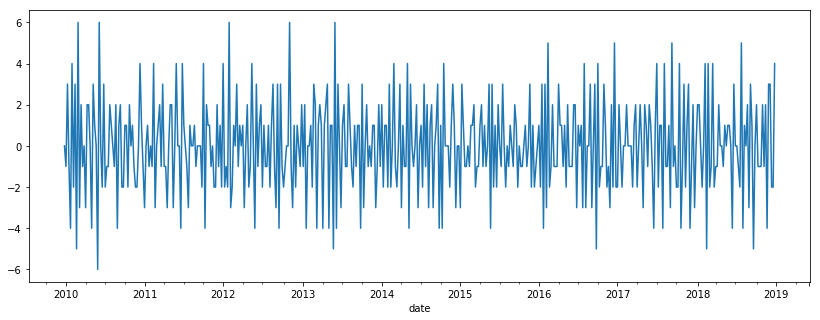

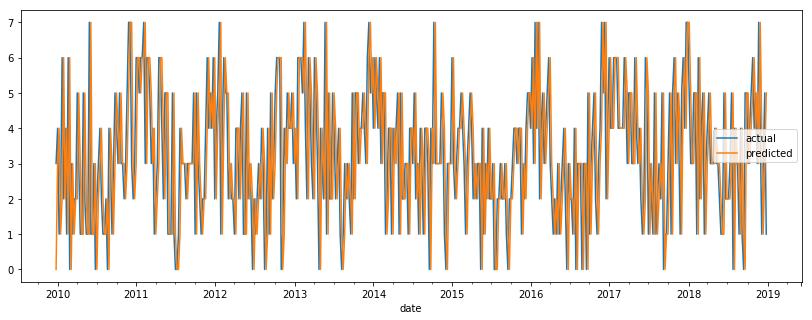

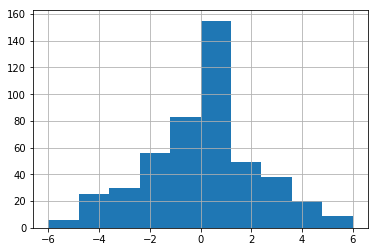

In [118]:
naive_results = evalute_model('naive', predict_naive, targets)

## Seasonal Naive

Uses the previous year's rainy day count as the forecast for this year's count.

In [119]:
def predict_snaive(df):
  return targets.shift(52)

Error: 2.0979213248714355
Error stats:
count    471.000000
mean      -0.053079
std        2.099480
min       -6.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: sn, dtype: float64
[[ 5  3  7  4  2  1  1  0]
 [19  4 13 10 10  4  2  3]
 [15 10 12 12  8 12  3  1]
 [12 22 14 21 16 10  7  2]
 [ 8  5 10 18 16 15  7  2]
 [ 7  6  8 17  7 12 11  2]
 [ 4  6  4  6  9  1  4  5]
 [ 3  1  0  2  5  3  2  0]]


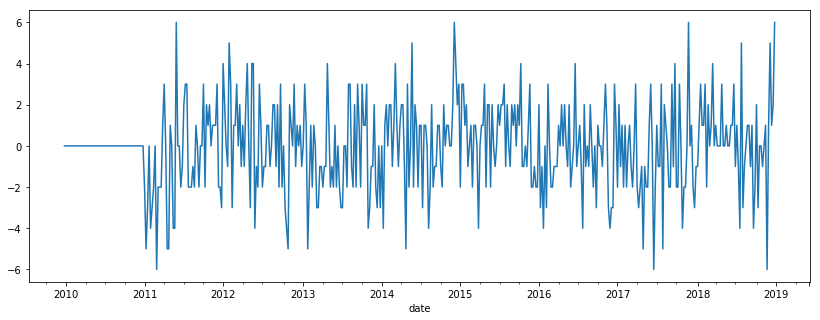

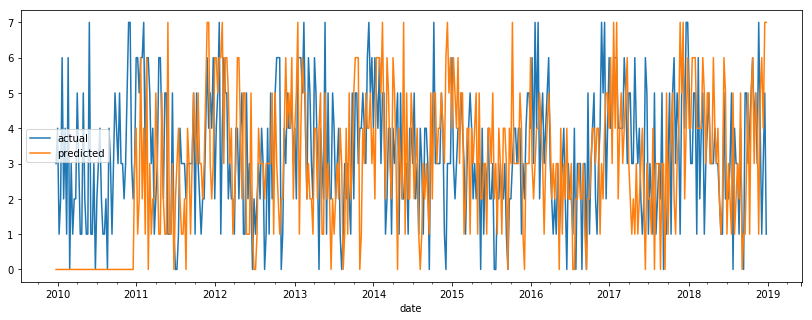

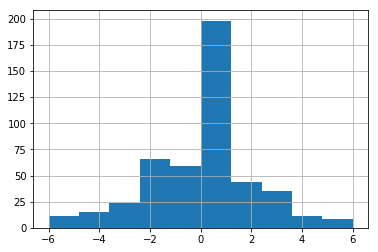

In [120]:
snaive_results = evalute_model('sn', predict_snaive, targets)

## Moving Average

In [121]:
def predict_ma(df, k=2):
  # shift(1) excludes the current instance from being included
  # in the MA
  return df.shift(1).rolling(k).mean().fillna(0).astype(int)

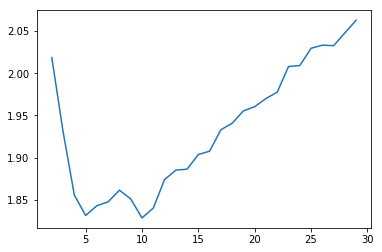

In [122]:
ma_results = []
ks = np.arange(2, 30)

for k in ks:
  preds = predict_ma(targets, k)
  results = results_df(targets, preds)
  model_score = score(results)
  ma_results.append(model_score)
  
plt.plot(range(2, 30), ma_results);

In [123]:
print('Best value for k:', ks[np.argmin(ma_results)])

Best value for k: 10


Error: 1.8315470935355829
Error stats:
count    471.000000
mean      -0.407643
std        1.787505
min       -6.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: ma, dtype: float64
[[ 0  2 16  4  0  1  0  0]
 [ 1  4 26 23 11  0  0  0]
 [ 1 11 25 22  9  5  0  0]
 [ 1 14 27 36 21  4  1  0]
 [ 1  5 23 28 15  8  1  0]
 [ 0  4 17 24 20  5  0  0]
 [ 1  0  4  9 17  8  0  0]
 [ 0  0  3  2  9  2  0  0]]


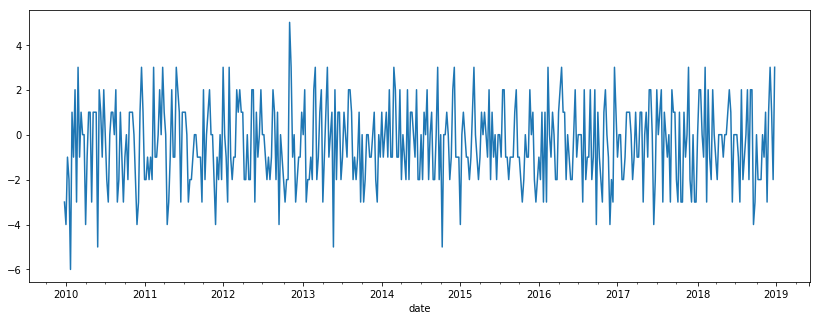

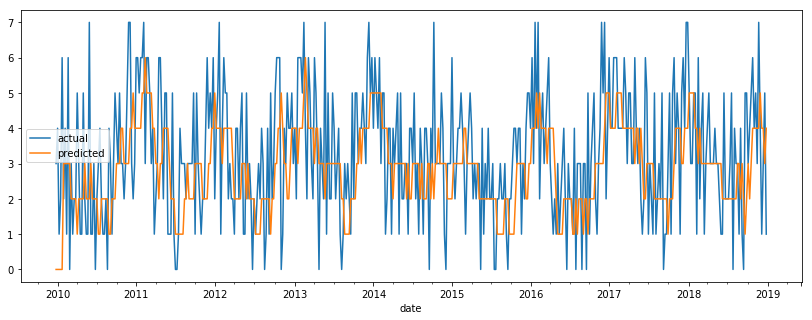

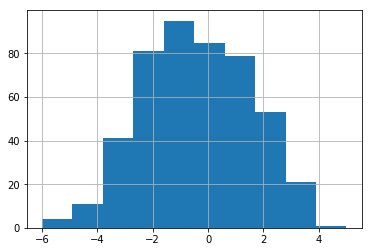

In [124]:
ma_results = evalute_model('ma', predict_ma, targets, k=5)

## Exponential Smoothing

In [125]:
def predict_ses(df):
  preds = []

  for ix in range(0, len(targets)):
    values = targets.iloc[0:ix+2]
    fit = SimpleExpSmoothing(values.astype(float)).fit()
    fcst = fit.forecast(1)
    preds.append(fcst.astype(int))
    
  results = pd.concat(preds, axis=0)
  results.index = df.index
  results[0:2] = None
  
  return results

Error: 1.594177303152115
Error stats:
count    471.000000
mean      -0.511677
std        1.511436
min       -5.000000
25%       -2.000000
50%       -1.000000
75%        1.000000
max        3.000000
Name: ses, dtype: float64
[[ 0  6 15  2  0  0  0  0]
 [ 0  2 40 22  1  0  0  0]
 [ 0  3 42 24  4  0  0  0]
 [ 1  2 50 36 14  1  0  0]
 [ 1  1 17 42 20  0  0  0]
 [ 0  0 19 30 20  1  0  0]
 [ 0  0  1 12 22  4  0  0]
 [ 0  0  2  5  9  0  0  0]]


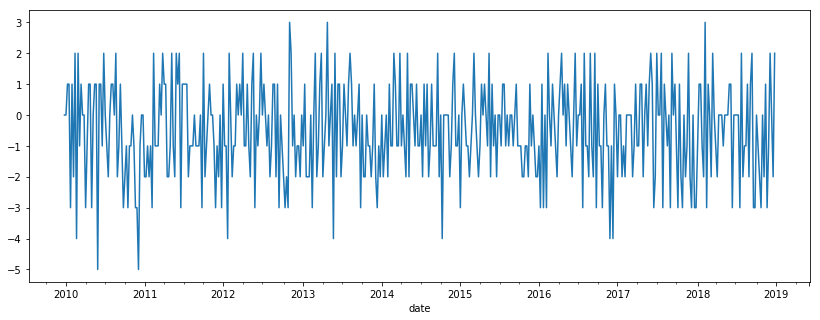

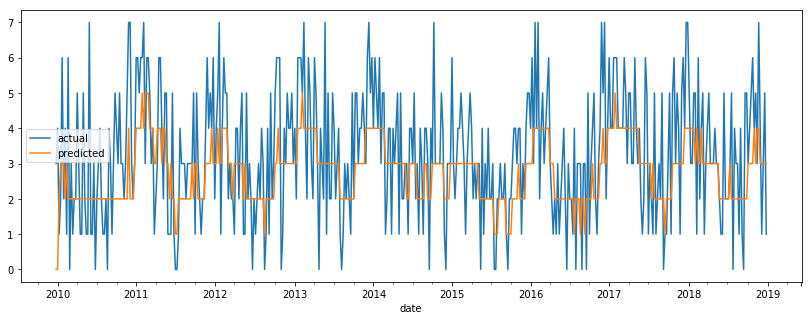

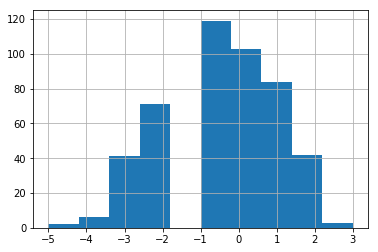

In [126]:
ses_results = evalute_model('ses', predict_ses, targets)

## Holt Winters

In [58]:
def pred_es(df, **kwargs):
  preds = []

  for ix in range(0, len(df)):
    values = targets.iloc[0:kwargs['seasonal_periods']+ix].astype(float)
    fcst = ExponentialSmoothing(values.astype(float), **kwargs).fit().forecast(1)
    preds.append(fcst.astype(int))
    
  results = pd.concat(preds, axis=0)
  results.index = df.index
  
  return results

In [59]:
(targets+.01).describe()

count    471.000000
mean       3.286008
std        1.769793
min        0.010000
25%        2.010000
50%        3.010000
75%        5.010000
max        7.010000
dtype: float64

In [60]:
models = []

for per in [2, 5, 10, 26, 52]:
  print('Number of periods:', per, end=' ')
  preds = pred_es(targets+.01, seasonal='add', seasonal_periods=per)
  per_score = score(results_df(targets, preds))
  print(per_score)
  models.append(per_score)

Number of periods: 2 

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:925: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:931: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


1.578787193425112
Number of periods: 5 1.6173160645507505
Number of periods: 10 

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: Co

1.6804104240351356
Number of periods: 26 

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2.0933622727792582
Number of periods: 52 

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


1.5399837316812433


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:925: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:931: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Error: 1.578787193425112
Error stats:
count    471.000000
mean      -0.535032
std        1.486945
min       -4.000000
25%       -2.000000
50%       -1.000000
75%        1.000000
max        3.000000
Name: hw, dtype: float64
[[ 0  5 16  2  0  0  0  0]
 [ 1  9 32 22  1  0  0  0]
 [ 0 10 35 22  6  0  0  0]
 [ 0  5 45 42 12  0  0  0]
 [ 0  3 17 37 23  1  0  0]
 [ 0  0 18 32 18  2  0  0]
 [ 0  0  0 13 23  3  0  0]
 [ 0  0  0  6  7  3  0  0]]


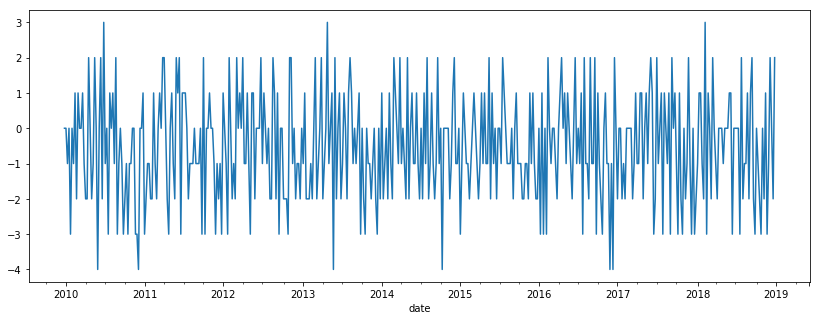

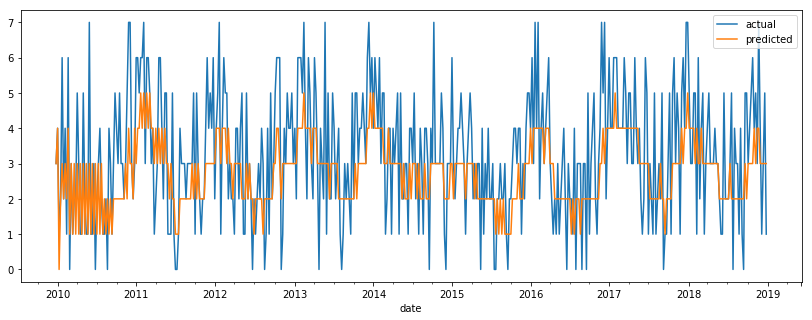

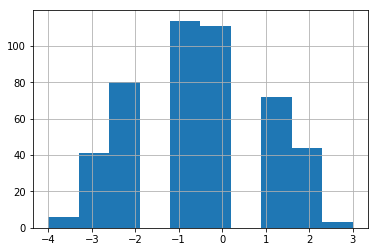

In [127]:
hw_results = evalute_model('hw', pred_es, targets, seasonal='add', seasonal_periods=2)

## SARIMA

In [35]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [42]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sarimax.SARIMAX(targets,
                                  order=param,
                                  seasonal_order=param_seasonal,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

            results = mod.fit()
  
            aics.append(results.aic)
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('ERROR: ARIMA{}x{}52: {}'.format(param, param_seasonal))
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:2684.3628473968274
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:2200.7357594632954
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:1934.9876636673887
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:1519.2478555784346
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:1910.9024396542736
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:1770.5771899641795
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:1572.6977952741054
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:1537.0683469973906
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:2419.427795894506
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:2062.0147218413294
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:1931.166334380084
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:1515.2929413763595
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:1902.7472668213695
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:1767.3189122120855
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:1573.9886441262624
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:1531.6485065862726
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:2160.7915993559186
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:1912.55970563

IndexError: tuple index out of range

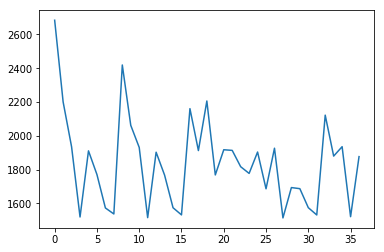

In [46]:
pd.Series(aics).plot();

In [50]:
pd.Series(aics).sort_values(ascending=True).head(5)

27    1513.688916
11    1515.292941
3     1519.247856
35    1521.047940
31    1531.216930
dtype: float64

In [53]:
mod = SARIMAX(targets,
              order=(0, 1, 1),
              seasonal_order=(0, 1, 1, 52),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0346      0.017    -60.035      0.000      -1.068      -1.001
ma.S.L52      -0.7534      0.057    -13.295      0.000      -0.865      -0.642
sigma2         2.6857      0.246     10.908      0.000       2.203       3.168


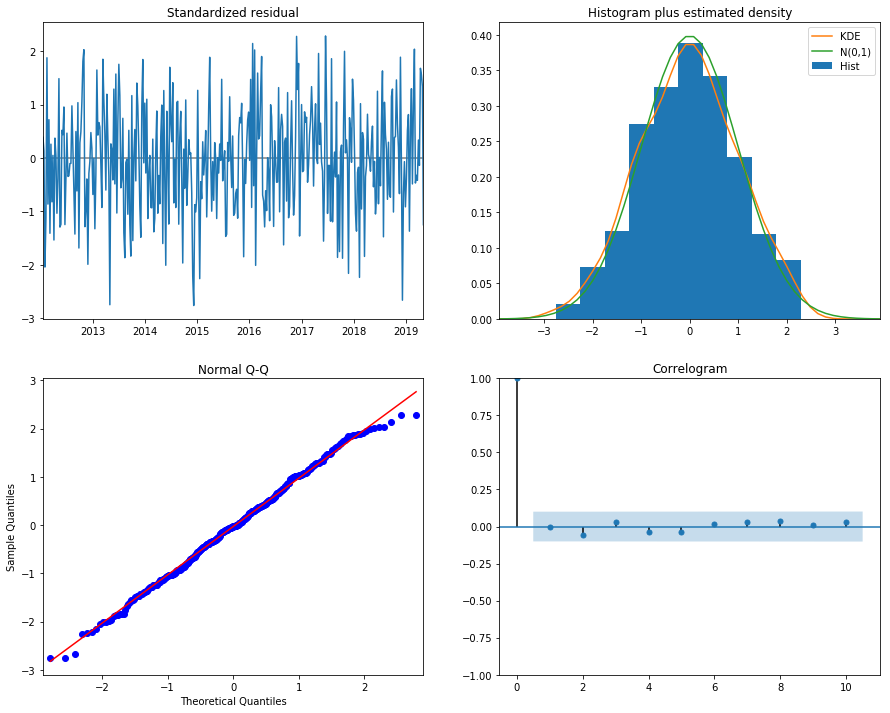

In [54]:
results.plot_diagnostics(figsize=(15, 12))
plt.show();

In [71]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-07'), dynamic=False)
pred_ci = pred.conf_int()

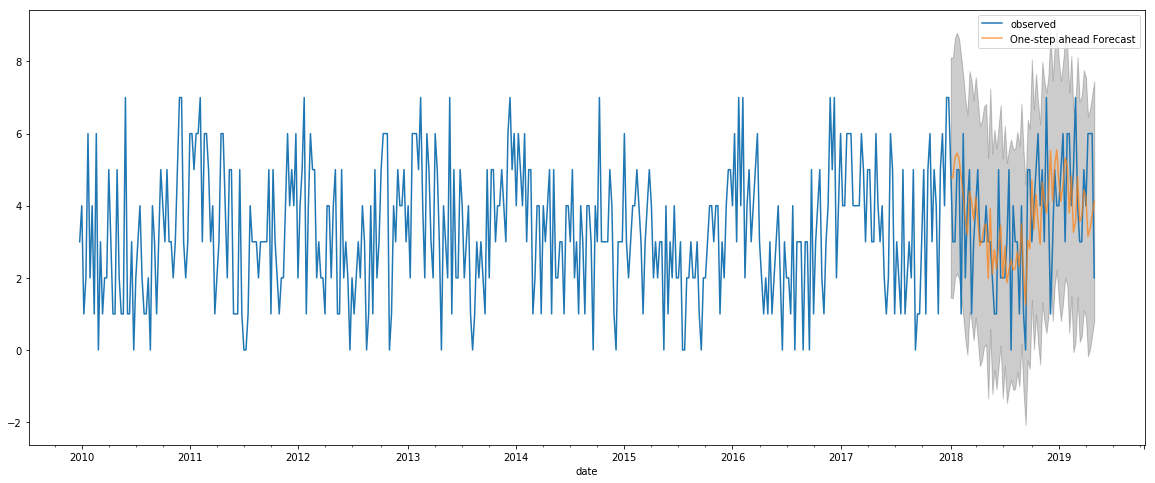

In [76]:
plt.figure(figsize=(20,8))
ax = targets.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()

plt.show()

# Results

In [91]:
pd.concat([naive_results[2], ma_results[2], ses_results[2], hw_results[2]], axis=1)

,naive,ma,ses,hw
count,471.000000,471.000000,471.000000,471.000000
mean,0.004246,-0.407643,-0.511677,-0.535032
std,2.237015,1.787505,1.511436,1.486945
min,-6.000000,-6.000000,-5.000000,-4.000000
25%,-1.000000,-2.000000,-2.000000,-2.000000
50%,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,6.000000,5.000000,3.000000,3.000000


Accuracy

In [92]:
model_preds = pd.DataFrame({
  'naive': naive_results[3],
  'ma': ma_results[3],
  'ses': ses_results[3],
  'hw': hw_results[3]
})
model_targets = pd.DataFrame({
  'naive': targets,
  'ma': targets,
  'ses': targets,
  'hw': targets
})
((model_preds == model_targets).sum(axis=0) / len(model_targets)).sort_values(ascending=False)

hw       0.235669
ses      0.214437
ma       0.180467
naive    0.165605
dtype: float64

Holt-Winters has the best accuracy at 25%. What happens when we take the majority vote or average?

# Ensemble

In [93]:
def predict_avg(df):
  return model_preds.apply(lambda row: row.mean().round(0).astype(int), axis=1)

Error: 1.7011298855388617
Error stats:
count    471.000000
mean      -0.375796
std        1.660866
min       -5.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: average, dtype: float64


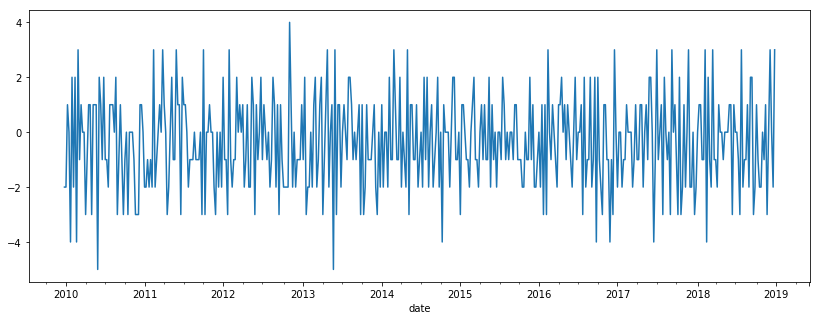

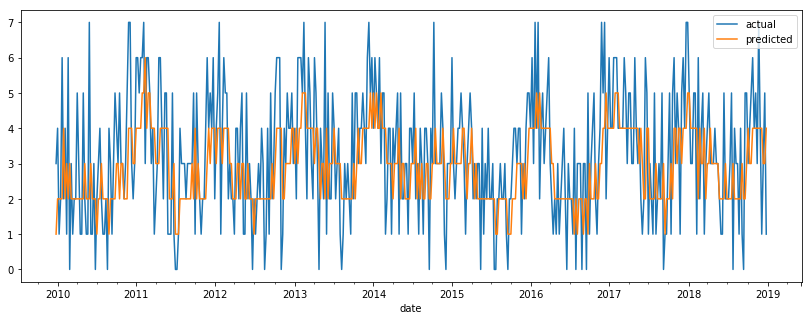

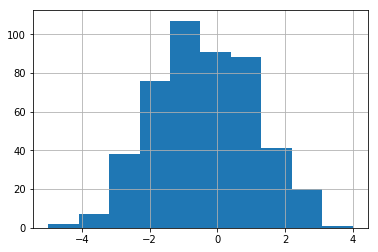

In [96]:
avg_results = evalute_model('average', predict_avg, targets)

In [94]:
avg_preds = predict_avg(targets)
(avg_preds == targets).sum() / len(model_targets)

0.1932059447983015

In [110]:
def predict_majority(targets):
  return model_preds.apply(lambda row: row.value_counts().idxmax(), axis=1)

Error: 1.7030009730546407
Error stats:
count    471.000000
mean      -0.407643
std        1.655251
min       -5.000000
25%       -2.000000
50%       -1.000000
75%        1.000000
max        6.000000
Name: majority, dtype: float64


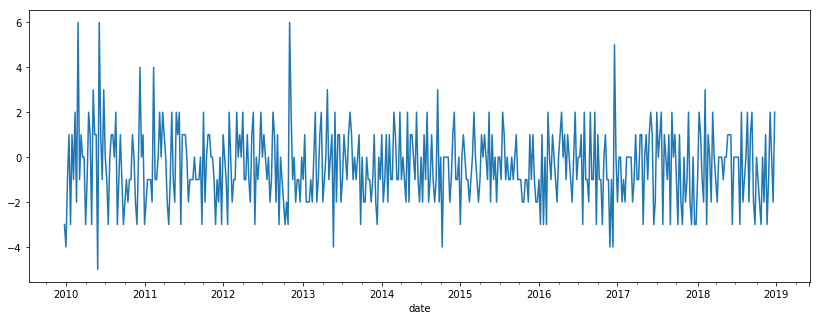

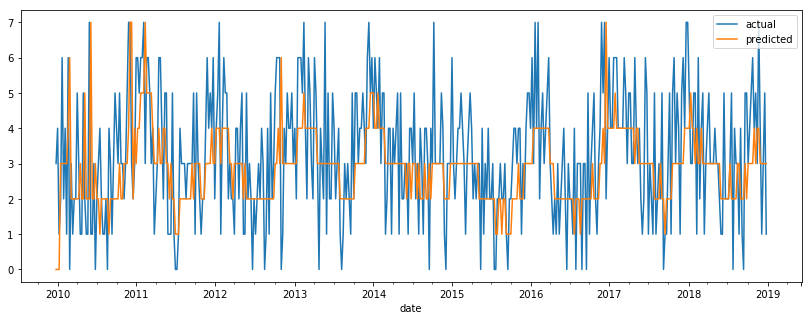

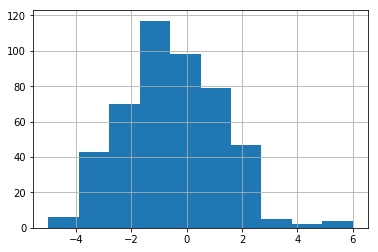

In [113]:
majority_results = evalute_model('majority', predict_majority, targets)

In [114]:
majority_preds = predict_majority(targets)
(majority_preds == targets).sum() / len(model_targets)

0.208067940552017